# Notebook showing a known-exoplanet yield estimation

This notebook shows how to use some of the newest features in psisim. It uses the upgraded universe.py class to pull confirmed planet data from the Exoplanet Archive. It then filters these planets to find reasonable VFN candidates based on basic properties (within VFN working region, reasonable mass, etc.). Those planets are fed into the updated spectrum.py which uses picaso to generate spectra for them.

To Add:
- remove intermediate resolution and wavelength sampling for this (VFN confirmed planets) specific analysis.
- Generate spectra for the host stars (using normal phoenix spectra).
- Pass these spectra into observation.py to determine detectability of the various targets.

Down the line:
- Perform quick SNR analysis using the analytical equations from Gary's 2018 SPIE paper.

In [1]:
from psisim import telescope,instrument,observation,spectrum,universe,plots,signal
import numpy as np
import time
import os
from importlib import reload
import speclite.filters
import copy
import astropy.units as u
from astropy.table import QTable, Table
import matplotlib.pylab as plt

SMALL_SIZE = 32
MEDIUM_SIZE = 40
BIGGER_SIZE = 48

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

## Telescope and instrument setup

In [2]:
#Setup the path to the peripheral files
path = '/scr3/dmawet/ETC/'
#Load the filter objects from speclite
filters = spectrum.load_filters()

In [3]:
#-- Telescope Setup
# Contains telescope params, site characteristics, and current conditions
keck = telescope.Keck(path=path)
keck.airmass=1.1
keck.water_vapor=1.6
keck.seeing = keck.median_seeing

In [4]:
#-- Instrument parameters
exp_time = 600           # [s]
main_filter = 'TwoMASS-K'   # Band for observation
n_exposures = 60
vort_charge = 1             # Vortex charge for VFN


#Initialize a kpic object and set the current filter
kpic = instrument.kpic_phaseII(telescope=keck)
kpic.set_current_filter(main_filter)

#Get the set of wavelengths based on the current instrument setup
wavelengths = kpic.get_wavelength_range()

# Set the observing mode: Exposure time (per exposure), Number of Exposures,filter name, wavelength array
kpic.set_observing_mode(exp_time,n_exposures,main_filter, wavelengths,mode="vfn",vortex_charge=vort_charge) 

## Create universe from Exoplanet Archive data

Load the universe from archive data

In [5]:
# Filename in which to save raw exoplanet archive table
archive_table_filename = "/scr3/dechever/Archive_Pull20210318.ecsv" 
# Instantiate universe object
uni = universe.ExoArchive_Universe(archive_table_filename)
# Pull and populate the planet table
uni.Load_ExoArchive_Universe(force_new_pull=False)

# Create easy-access table variables
planet_table = uni.planets
full_planet_table = copy.deepcopy(uni.planets)

# Display the table
planet_table

/scr3/dechever/Archive_Pull20210318.ecsv already exists:
    we'll attempt to read this file as an astropy QTable


PlanetName,StarName,SMA,Ecc,Inc,PlanetMass,PlanetRadius,PlanetTeq,RA,Dec,Distance,StarSpT,StarMass,StarTeff,StarRad,StarLogg,StarLum,StarAge,StarVsini,StarRadialVelocity,StarZ,StarParallax,StarBMag,StarVmag,StarRmag,StarImag,StarJmag,StarHmag,StarKmag,DiscoveryMethod,Flux Ratio,ProjAU,Phase,AngSep,PlanetLogg
,,AU,,deg,earthMass,earthRad,K,deg,deg,pc,,solMass,K,solRad,dex(cm / s2),solLum,Gyr,km / s,km / s,,mas,,,,,,,,,,AU,rad,mas,dex(cm / s2)
object,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,str32,float64,float64,float64,float64,float64,float64,float64,float64,object,float64,float64,float64,float64,float64
HD 20794 c,HD 20794,0.2036,0.0,90.0,2.4,1.35,508.0,49.9997666,-43.0666533,6.00278,G8 V,0.7,5401.0,0.92,4.22,0.6870684400142322,5.76,3.0,87.95,-0.5,166.561,4.966,4.26,nan,3.465,3.032,2.709,2.636,Radial Velocity,nan,nan,nan,33.91761817024779,3.110698786682366
HD 20794 d,HD 20794,0.3499,0.0,90.0,4.8,2.04,388.0,49.9997666,-43.0666533,6.00278,G8 V,0.7,5401.0,0.92,4.22,0.6870684400142322,5.76,3.0,87.95,-0.5,166.561,4.966,4.26,nan,3.465,3.032,2.709,2.636,Radial Velocity,nan,nan,nan,58.289659124605606,3.053135984484562
HD 208487 b,HD 208487,0.524,0.24,nan,165.265,14.2,nan,329.3332489,-37.7641354,45.147,G2 V,1.13,6067.0,1.2,4.33,1.7538805018417611,8.15,4.61,5.49,-0.0,22.1214,8.023,7.47,nan,nan,6.477,6.213,6.159,Radial Velocity,nan,nan,nan,11.60652978049483,2.9047592811501257
HD 20868 b,HD 20868,0.95,0.75,nan,397.2875,13.7,nan,50.1794053,-33.72969,47.7223,K3/4 IV,0.39,4802.0,0.76,4.26,0.29580124665515456,4.5,1.1,46.12,-0.0,20.9257,10.935,9.92,nan,nan,8.138,7.641,7.543,Radial Velocity,nan,nan,nan,19.906836007484973,3.3168188485542527
HD 209458 b,HD 209458,0.04707,0.0,86.71,232.0159,15.581,1459.0,330.7950219,18.8842419,48.3016,G0 V,1.23,6091.0,1.19,4.45,1.7021585083949506,3.1,4.4,-14.74,-0.0,20.6745,8.168,7.65,nan,7.037,6.591,6.366,6.308,Radial Velocity,nan,nan,nan,0.9745018798549115,2.971482174841042
HD 210277 b,HD 210277,1.13,0.48,nan,410.0007,13.6,nan,332.3748117,-7.5505962,21.2985,G0 V,1.01,5538.0,1.07,4.38,0.9289663867799364,12.0,1.8,-21.1,-0.0,46.9229,7.296,6.54348,nan,5.765,5.275,4.957,4.799,Radial Velocity,nan,nan,nan,53.05537948681832,3.3368618634178238
HD 210702 b,HD 210702,1.148,0.028,nan,574.63664,13.4,nan,332.9638643,16.0404806,54.1963,K1 III,1.61,4951.0,4.92,3.28,14.092887984218748,2.1,1.99,16.39,-0.0,18.4231,6.895,5.93022,nan,nan,4.508,3.995,3.984,Radial Velocity,nan,nan,nan,21.182257829409018,3.496338799268739
HD 212301 b,HD 212301,0.03,0.0,nan,162.0933,14.2,nan,336.8803957,-77.7183219,54.2304,F8 V,1.55,6239.0,1.16,4.5,1.7498466886246569,1.0,7.0,4.87,-0.0,18.4109,8.314,7.76,nan,nan,6.765,6.522,6.466,Radial Velocity,nan,nan,nan,0.5531952557974862,2.896343457190833


## Select promising targets for modeling

##### First, remove planets missing key parameters needed for picaso

In [6]:
# Create masks for missing entries by (relevant) column
sma_mask = np.logical_not(np.isnan(planet_table['SMA']))
pms_mask = np.logical_not(np.isnan(planet_table['PlanetMass']))
prd_mask = np.logical_not(np.isnan(planet_table['PlanetRadius']))
plg_mask = np.logical_not(np.isnan(planet_table['PlanetLogg'])) 
ptq_mask = np.logical_not(np.isnan(planet_table['PlanetTeq']))
slg_mask = np.logical_not(np.isnan(planet_table['StarLogg'])) 
stf_mask = np.logical_not(np.isnan(planet_table['StarTeff'])) 
srd_mask = np.logical_not(np.isnan(planet_table['StarRad']))

# Addtionally, remove planets missing AngSep
  # Not needed by picaso but needed for VFN part of simulations 
  # These entries are rare; the only 1 at the moment is beause of a missing star distance
ang_mask = np.logical_not(np.isnan(planet_table['AngSep']))

# Combine masks
com_mask = sma_mask & pms_mask & prd_mask & plg_mask & ptq_mask & slg_mask & stf_mask & srd_mask & ang_mask
print('Number of planets with sufficient information: %d'%np.sum(com_mask))

planet_table = planet_table[com_mask]

# Display the new table
planet_table

Number of planets with sufficient information: 3218


PlanetName,StarName,SMA,Ecc,Inc,PlanetMass,PlanetRadius,PlanetTeq,RA,Dec,Distance,StarSpT,StarMass,StarTeff,StarRad,StarLogg,StarLum,StarAge,StarVsini,StarRadialVelocity,StarZ,StarParallax,StarBMag,StarVmag,StarRmag,StarImag,StarJmag,StarHmag,StarKmag,DiscoveryMethod,Flux Ratio,ProjAU,Phase,AngSep,PlanetLogg
,,AU,,deg,earthMass,earthRad,K,deg,deg,pc,,solMass,K,solRad,dex(cm / s2),solLum,Gyr,km / s,km / s,,mas,,,,,,,,,,AU,rad,mas,dex(cm / s2)
object,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,str32,float64,float64,float64,float64,float64,float64,float64,float64,object,float64,float64,float64,float64,float64
HD 20794 c,HD 20794,0.2036,0.0,90.0,2.4,1.35,508.0,49.9997666,-43.0666533,6.00278,G8 V,0.7,5401.0,0.92,4.22,0.6870684400142322,5.76,3.0,87.95,-0.5,166.561,4.966,4.26,nan,3.465,3.032,2.709,2.636,Radial Velocity,nan,nan,nan,33.91761817024779,3.110698786682366
HD 20794 d,HD 20794,0.3499,0.0,90.0,4.8,2.04,388.0,49.9997666,-43.0666533,6.00278,G8 V,0.7,5401.0,0.92,4.22,0.6870684400142322,5.76,3.0,87.95,-0.5,166.561,4.966,4.26,nan,3.465,3.032,2.709,2.636,Radial Velocity,nan,nan,nan,58.289659124605606,3.053135984484562
HD 209458 b,HD 209458,0.04707,0.0,86.71,232.0159,15.581,1459.0,330.7950219,18.8842419,48.3016,G0 V,1.23,6091.0,1.19,4.45,1.7021585083949506,3.1,4.4,-14.74,-0.0,20.6745,8.168,7.65,nan,7.037,6.591,6.366,6.308,Radial Velocity,nan,nan,nan,0.9745018798549115,2.971482174841042
HD 285968 b,HD 285968,0.066,0.0,nan,8.4,2.83,450.0,70.7353853,18.953358,9.47045,M2 V,0.5,3543.0,0.49,4.75,0.021978598727848252,3.62,0.8,26.41,-0.0,105.563,11.401,9.95,9.557,7.72,6.462,5.824,5.607,Radial Velocity,nan,nan,nan,6.969045821476277,3.0118614969740736
HD 330075 b,HD 330075,0.04,0.0,nan,152.5584,14.3,990.0,237.4054997,-49.9639199,45.2989,K1,0.47,5000.0,0.84,4.26,0.4677351412871982,6.2,0.7,61.28,-0.0,22.0467,10.356,9.36,nan,nan,7.725,7.253,7.171,Radial Velocity,nan,nan,nan,0.8830236495808949,2.8639191323044733
HD 40307 b,HD 40307,0.0468,0.2,nan,4.0,1.83,910.0,88.5172191,-60.0237289,12.9363,K2.5 V,0.77,4956.0,0.72,4.47,0.2296148648112362,4.5,1.0,31.33,-0.5,77.2727,8.109,7.17,nan,nan,5.412,4.968,4.793,Radial Velocity,nan,nan,nan,3.617726861621948,3.068312893827876
HD 40307 c,HD 40307,0.0799,0.06,nan,6.6,2.46,696.0,88.5172191,-60.0237289,12.9363,K2.5 V,0.77,4956.0,0.72,4.47,0.2296148648112362,4.5,1.0,31.33,-0.5,77.2727,8.109,7.17,nan,nan,5.412,4.968,4.793,Radial Velocity,nan,nan,nan,6.176418295803282,3.028828803295883
HD 40307 d,HD 40307,0.1321,0.07,nan,9.5,3.04,541.0,88.5172191,-60.0237289,12.9363,K2.5 V,0.77,4956.0,0.72,4.47,0.2296148648112362,4.5,1.0,31.33,-0.5,77.2727,8.109,7.17,nan,nan,5.412,4.968,4.793,Radial Velocity,nan,nan,nan,10.21157517992007,3.0031315200321127


##### Next, downselect based on VFN coupling region

In [7]:
#Down select the planets whose separations are beyond VFN coupling region
iwa = 0.4*np.median(wavelengths).to(u.m)/keck.diameter*u.rad
owa = 1.4*np.median(wavelengths).to(u.m)/keck.diameter*u.rad

planet_table = planet_table[planet_table['AngSep'] > iwa.to(u.mas)]
planet_table = planet_table[planet_table['AngSep'] < owa.to(u.mas)]

# Display the new table
planet_table

PlanetName,StarName,SMA,Ecc,Inc,PlanetMass,PlanetRadius,PlanetTeq,RA,Dec,Distance,StarSpT,StarMass,StarTeff,StarRad,StarLogg,StarLum,StarAge,StarVsini,StarRadialVelocity,StarZ,StarParallax,StarBMag,StarVmag,StarRmag,StarImag,StarJmag,StarHmag,StarKmag,DiscoveryMethod,Flux Ratio,ProjAU,Phase,AngSep,PlanetLogg
,,AU,,deg,earthMass,earthRad,K,deg,deg,pc,,solMass,K,solRad,dex(cm / s2),solLum,Gyr,km / s,km / s,,mas,,,,,,,,,,AU,rad,mas,dex(cm / s2)
object,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,str32,float64,float64,float64,float64,float64,float64,float64,float64,object,float64,float64,float64,float64,float64
HD 20794 c,HD 20794,0.2036,0.0,90.0,2.4,1.35,508.0,49.9997666,-43.0666533,6.00278,G8 V,0.7,5401.0,0.92,4.22,0.6870684400142322,5.76,3.0,87.95,-0.5,166.561,4.966,4.26,nan,3.465,3.032,2.709,2.636,Radial Velocity,nan,nan,nan,33.91761817024779,3.110698786682366
HD 20794 d,HD 20794,0.3499,0.0,90.0,4.8,2.04,388.0,49.9997666,-43.0666533,6.00278,G8 V,0.7,5401.0,0.92,4.22,0.6870684400142322,5.76,3.0,87.95,-0.5,166.561,4.966,4.26,nan,3.465,3.032,2.709,2.636,Radial Velocity,nan,nan,nan,58.289659124605606,3.053135984484562
HD 85512 b,HD 85512,0.26,0.11,90.0,3.6,1.72,298.0,147.7821226,-43.5048162,11.281,K5 V,0.43,4300.0,0.71,4.36,0.16788040181225602,5.61,3.0,-9.49,-0.5,88.6158,8.743,7.67,nan,6.328,5.451,4.998,4.717,Radial Velocity,nan,nan,nan,23.04760216292882,3.076400688912962
HD 86226 b,HD 86226,2.73,0.059,nan,143.0235,14.3,176.0,149.1235154,-24.0991859,45.683,G1 V,1.02,5863.0,1.05,4.4,1.1803206356517297,4.6,2.4,19.74,-0.0,21.8612,8.432,7.93,nan,nan,6.839,6.577,6.463,Radial Velocity,nan,nan,nan,59.759648009106236,2.8358904087042296
HD 40307 f,HD 40307,0.247,0.02,nan,5.2,2.13,398.0,88.5172191,-60.0237289,12.9363,K2.5 V,0.77,4956.0,0.72,4.47,0.2296148648112362,4.5,1.0,31.33,-0.5,77.2727,8.109,7.17,nan,nan,5.412,4.968,4.793,Radial Velocity,nan,nan,nan,19.093558436338057,3.050399218718096
HD 40307 g,HD 40307,0.6,0.29,nan,7.1,2.56,255.0,88.5172191,-60.0237289,12.9363,K2.5 V,0.77,4956.0,0.72,4.47,0.2296148648112362,4.5,1.0,31.33,-0.5,77.2727,8.109,7.17,nan,nan,5.412,4.968,4.793,Radial Velocity,nan,nan,nan,46.38111361053779,3.0259335000561487
GJ 338 B b,GJ 338 B,0.141,0.11,nan,10.27,3.19,391.0,138.5916722,52.6835211,6.33256,M0.0 V,0.64,4005.0,0.58,4.68,0.07925013304804718,4.0,2.3,11.8,-0.0,157.885,9.117,7.7,nan,nan,4.779,4.043,4.136,Radial Velocity,nan,nan,nan,22.265876675467737,2.9951441594436883
GJ 887 b,GJ 887,0.068,0.0,nan,4.2,1.88,468.0,346.4668274,-35.8530693,3.29,M1 V,0.49,3688.0,0.47,4.78,0.036812897364253146,2.88,2.5,8.17,-0.0,303.9,8.83,7.35,nan,5.32,nan,nan,3.465,Radial Velocity,nan,nan,nan,20.66869300911854,3.066088673831313


##### Make additional cuts based on mass

In [8]:
# Make sure we're in the giant planet regime for now
planet_table = planet_table[planet_table['PlanetMass'].to(u.earthMass).value > 130]
# Remove objects above the hydrogen burning limit
planet_table = planet_table[planet_table['PlanetMass'].to(u.earthMass).value < 4200]

# Display the new table
planet_table

PlanetName,StarName,SMA,Ecc,Inc,PlanetMass,PlanetRadius,PlanetTeq,RA,Dec,Distance,StarSpT,StarMass,StarTeff,StarRad,StarLogg,StarLum,StarAge,StarVsini,StarRadialVelocity,StarZ,StarParallax,StarBMag,StarVmag,StarRmag,StarImag,StarJmag,StarHmag,StarKmag,DiscoveryMethod,Flux Ratio,ProjAU,Phase,AngSep,PlanetLogg
,,AU,,deg,earthMass,earthRad,K,deg,deg,pc,,solMass,K,solRad,dex(cm / s2),solLum,Gyr,km / s,km / s,,mas,,,,,,,,,,AU,rad,mas,dex(cm / s2)
object,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,str32,float64,float64,float64,float64,float64,float64,float64,float64,object,float64,float64,float64,float64,float64
HD 86226 b,HD 86226,2.73,0.059,nan,143.0235,14.3,176.0,149.1235154,-24.0991859,45.683,G1 V,1.02,5863.0,1.05,4.4,1.1803206356517297,4.6,2.4,19.74,-0.0,21.8612,8.432,7.93,nan,nan,6.839,6.577,6.463,Radial Velocity,nan,nan,nan,59.759648009106236,2.8358904087042296
GJ 3021 b,GJ 3021,0.49,0.511,nan,1071.04,13.1,350.0,4.0634323,-79.8514218,17.5559,G6 V,0.9,5540.0,0.9,4.7,0.660693448007596,0.37,5.5,-5.81,-0.0,56.9319,7.352,6.59,nan,nan,5.366,4.99,4.859,Radial Velocity,nan,nan,nan,27.910844787222526,3.786418181326927
HD 169830 b,HD 169830,0.81,0.31,nan,915.31,13.2,345.0,276.9561859,-29.8167919,37.6048,F8 V,1.4,6299.0,1.2,4.1,4.591980128368687,2.8,3.3,-17.21,-0.0,26.5642,6.407,5.9,nan,nan,4.974,4.778,4.688,Radial Velocity,nan,nan,nan,21.539803429349448,3.7115754267173204


#### FOR NOW: set phase to 0 for all planets.

#### WE SHOULD find a good way to decide on the planet phase

In [9]:
planet_table['Phase'][:] = 0.0 *u.rad

## Prepare for spectrum creation (compute intermediate sampling)

In [13]:
# We're going to generate a model spectrum at a resolution twice the 
# requested resolution
intermediate_R = kpic.current_R*2
#Choose the model wavelength range to be just a little bigger than 
#the observation wavelengths
model_wv_low = 1.*np.min(kpic.current_wvs) 
model_wv_high = 1.*np.max(kpic.current_wvs)

#Figure out a good wavelength spacing for the model
wv_c = 0.5*(model_wv_low+model_wv_high) #Central wavelength of the model
dwv_c = wv_c/intermediate_R #The delta_lambda at the central wavelength
#The number of wavelengths to generate. Divide by two for nyquist in the d_wv. 
#Multiply the final number by 2 just to be safe.
n_model_wv = int((model_wv_high-model_wv_low)/(dwv_c/2))*2
#Generate the model wavelenths
model_wvs = np.linspace(model_wv_low, model_wv_high, n_model_wv) #Choose some wavelengths

## Define function to generate planet spectrum

In [14]:
# Define opacity file to load
  # None tells picaso to use the default file
opacity_folder = os.path.join(os.getenv("picaso_refdata"),'opacities')
dbname = 'Natasha Batalha - opacity_K.db'
dbname = os.path.join(opacity_folder,dbname)
# Define wavelength range for opacity file
  # Not required but will reduce picaso runtime since not simulating unused wavelengths
  # Set slightly larger than requested wvs due to apparent picaso internal rounding on wave_range
wvrng = [model_wvs.min().value*0.98, model_wvs.max().value*1.02]

# Load opacity file
opacity = spectrum.load_picaso_opacity(dbname=dbname,wave_range=wvrng)

# Function that actually does the simulation
def generate_spectrum(planet):
    """
    Function to loop over to generate spectra.
    """
    # For now, we'll assume user has filtered planet table so that 
    #  all planets are gas giants. This is because the psisim picaso
    #  implementation is limited to gas giants for now
    planet_type = "Gas"
    print('-----')
    print('  STARTING NEW PLANET')
    print('Planet Name: %s'%planet['PlanetName'])
    
    # Extract planet equilibrium temperature
    # Unecessary right now due to earlier masking but maybe useful laeter
    planet_teq = planet['PlanetTeq'].value if not np.isnan(planet['PlanetTeq']) else None
    print('Planet Teq in use: %0.1f'%planet_teq)

    # Generate spectrum at intermediate resolution
    time1 = time.time()
    atmospheric_parameters = spectrum.generate_picaso_inputs(planet,planet_type,opacity,clouds=True,planet_teq=planet_teq)
    fpfs = spectrum.simulate_spectrum(planet,model_wvs,intermediate_R,atmospheric_parameters)
    print('Spectrum took {0:.3f} s'.format(time.time()-time1))
    
    return fpfs

## Generate spectra!

##### NOTE: we will iterate over the full planet table below so make sure you've culled the planet_table to be small enough so that this iteration is manageable

In [16]:
fpfs_list = []

for planet in planet_table:
    fpfs = generate_spectrum(planet)
    fpfs_list.append(fpfs)
    
fpfs_list = np.array(fpfs_list)

-----
  STARTING NEW PLANET
Planet Name: HD 86226 b
Planet Teq in use: 176.0


/home/dechever/anaconda3/lib/python3.7/site-packages/picaso-2.1-py3.7.egg/picaso/atmsetup.py:185: UserWarning: Ignoring graphite in input file, not a recognized molecule
  warnings.warn("Ignoring %s in input file, not a recognized molecule" % i, UserWarning)
/home/dechever/anaconda3/lib/python3.7/site-packages/picaso-2.1-py3.7.egg/picaso/atmsetup.py:185: UserWarning: Ignoring lithium(c) in input file, not a recognized molecule
  warnings.warn("Ignoring %s in input file, not a recognized molecule" % i, UserWarning)
/home/dechever/anaconda3/lib/python3.7/site-packages/picaso-2.1-py3.7.egg/picaso/atmsetup.py:185: UserWarning: Ignoring ptid in input file, not a recognized molecule
  warnings.warn("Ignoring %s in input file, not a recognized molecule" % i, UserWarning)


Spectrum took 7.249 s
-----
  STARTING NEW PLANET
Planet Name: GJ 3021 b
Planet Teq in use: 350.0
Spectrum took 6.430 s
-----
  STARTING NEW PLANET
Planet Name: HD 169830 b
Planet Teq in use: 345.0
Spectrum took 6.121 s


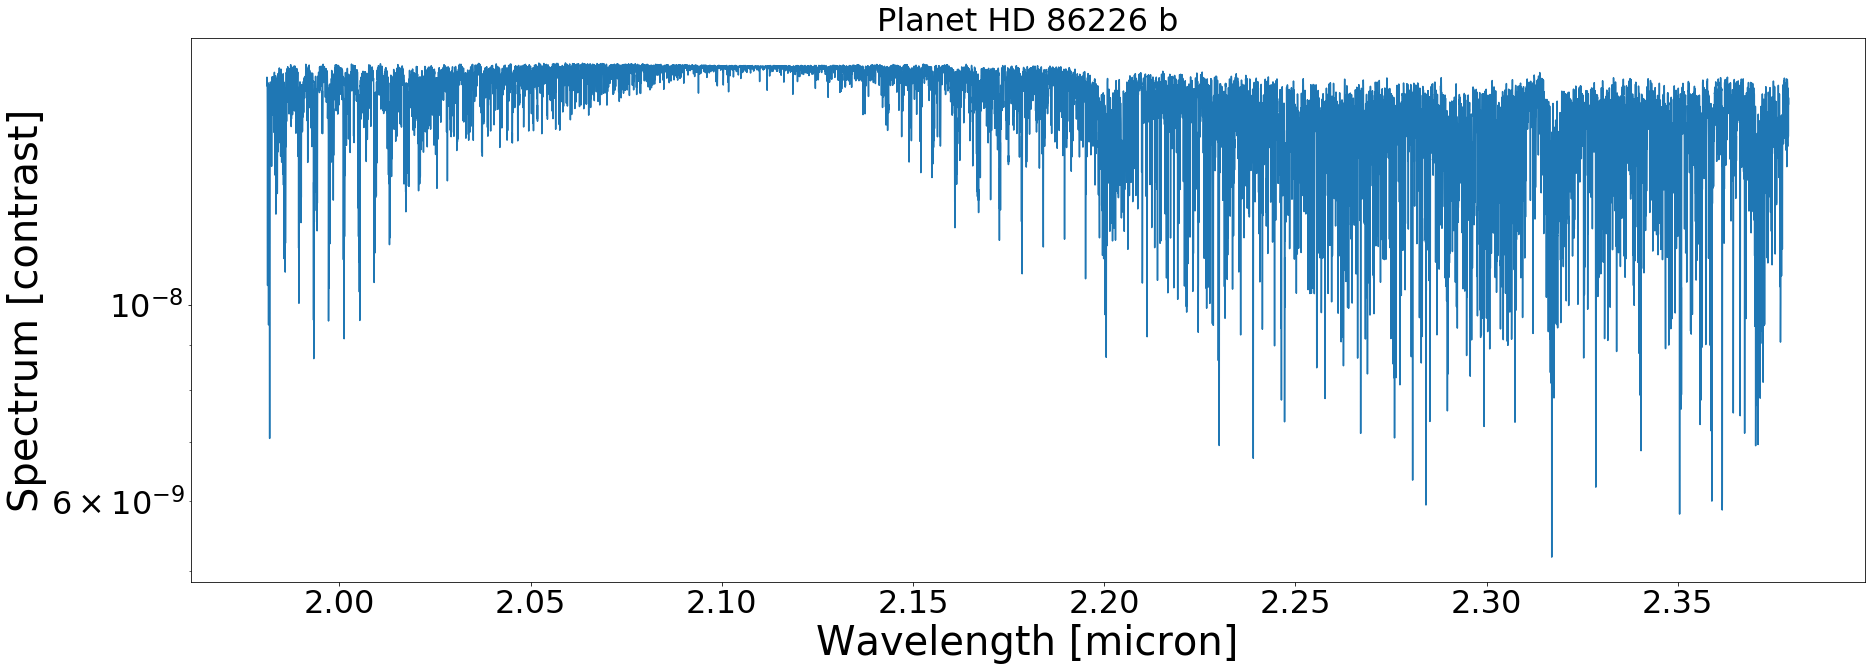

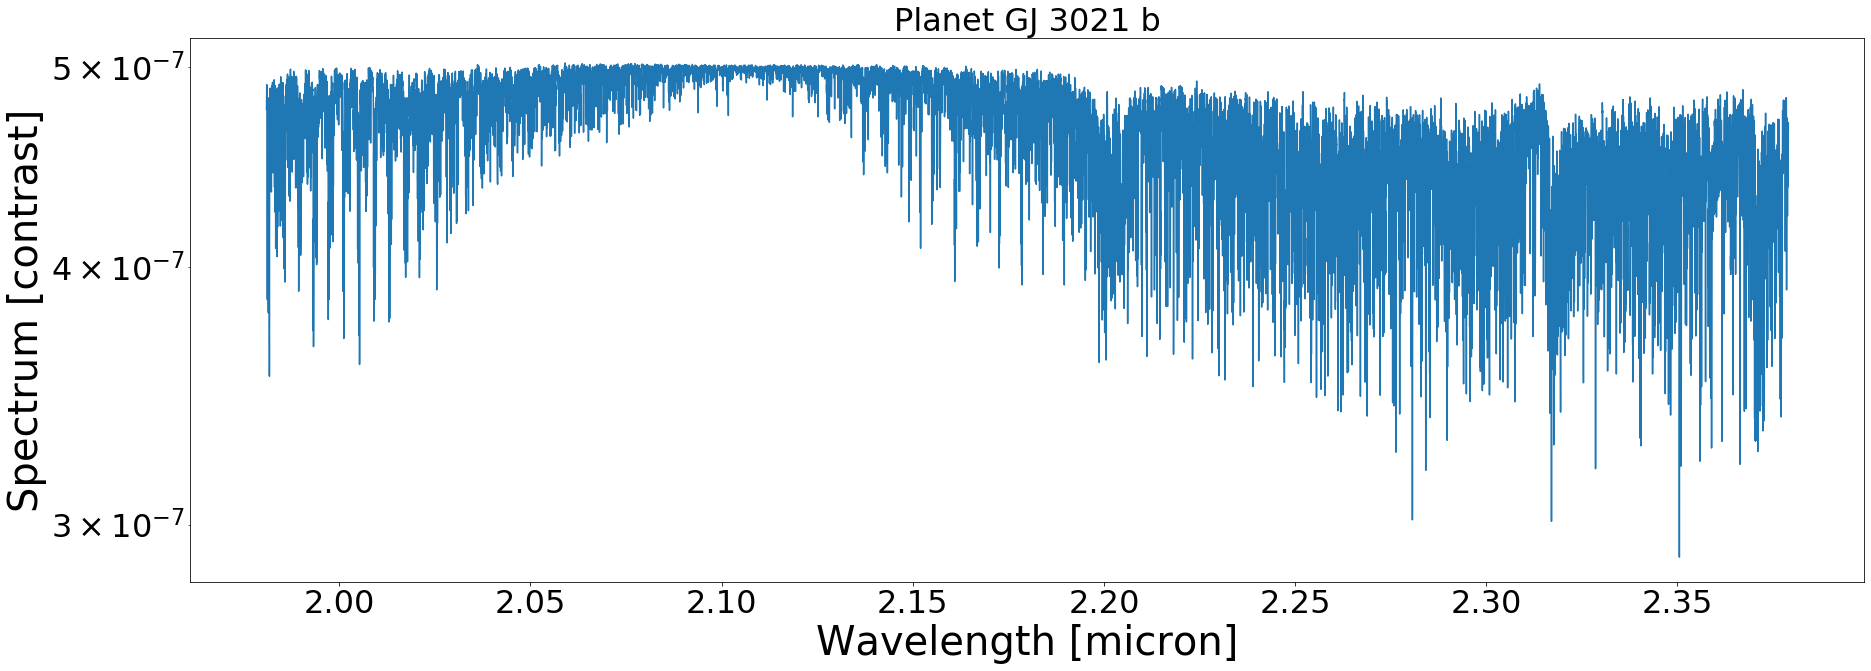

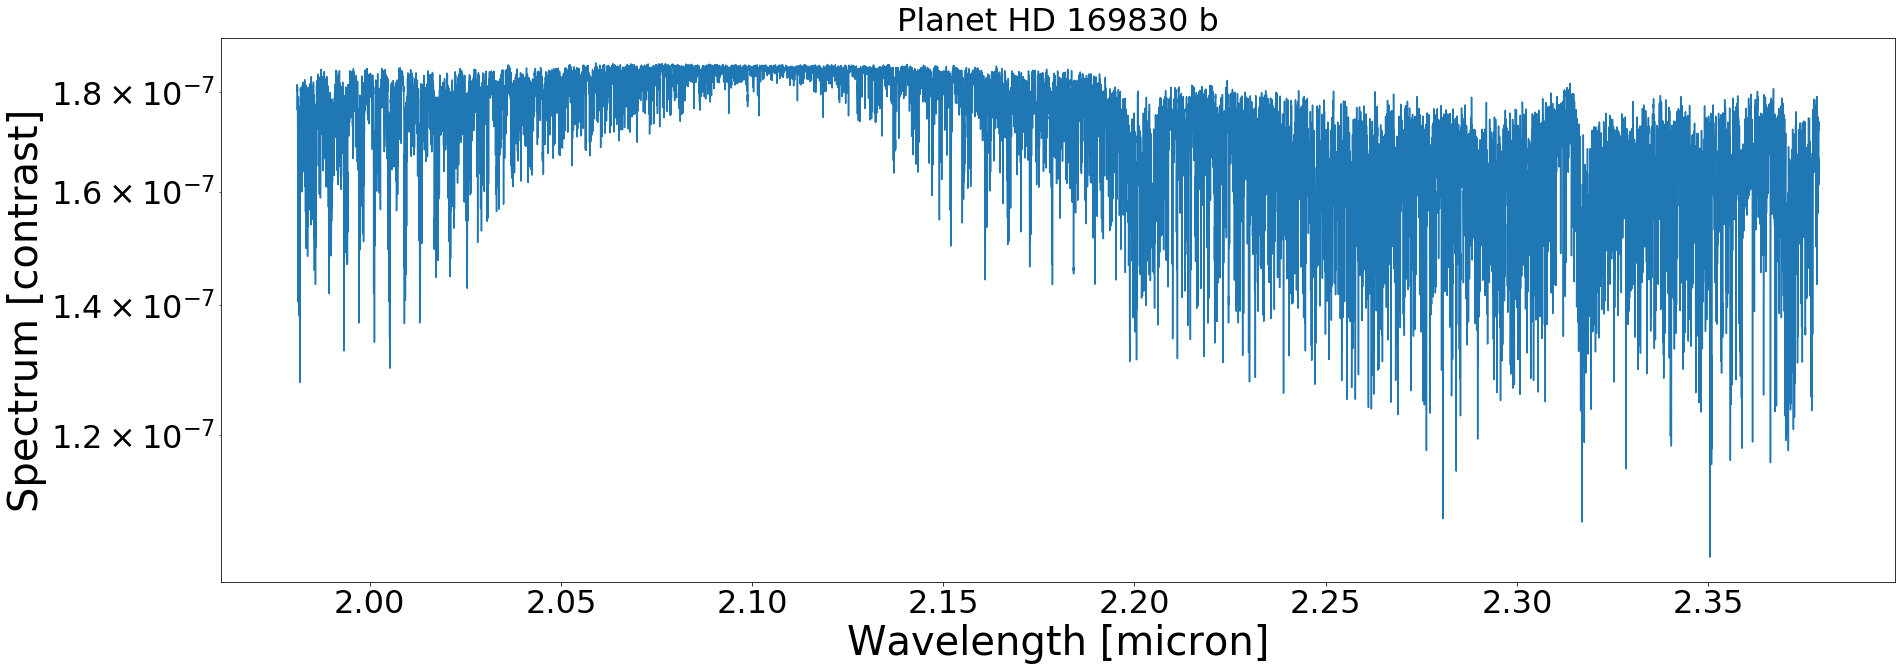

In [17]:
for ind in range(len(planet_table)):
    plt.figure(figsize=(30,10))
    plt.semilogy(model_wvs,fpfs_list[ind])
    plt.xlabel("Wavelength [{}]".format(wavelengths.unit))
    plt.ylabel("Spectrum [contrast]")
    plt.title("Planet %s"%planet_table['PlanetName'][ind])

# Below this point are miscellaneous notes

Cells below this are notes I'm keeping for reference while making this notebook. I'll delete them as I move further in the notebook

In [32]:
tmp_wvs = opacity.wave
tmp_dwvs = np.abs(tmp_wvs - np.roll(tmp_wvs,1))
tmp_dwvs[0] = tmp_dwvs[1]
tmp_R = tmp_wvs/tmp_dwvs

np.mean(tmp_R)

#tmp_dwvs

tmp_wvs

array([2.3799897, 2.3799699, 2.3799501, ..., 1.9800495, 1.9800297,
       1.9800099])

In [24]:
intermediate_R

70000.0

In [31]:
np.abs(model_wvs - np.roll(model_wvs,1)).value
#model_wvs

array([3.97984952e-01, 7.78606969e-06, 7.78606969e-06, ...,
       7.78606969e-06, 7.78606969e-06, 7.78606969e-06])

In [30]:
kpic.current_dwvs

<Quantity [2.07619048e-05, 2.07619048e-05, 2.07619048e-05, ...,
           2.07619048e-05, 2.07619048e-05, 2.07619048e-05] micron>

In [27]:
wavelengths

<Quantity [1.981     , 1.98102076, 1.98104152, ..., 2.37894343, 2.37896419,
           2.37898495] micron>

In [1]:
import picaso
import os
from picaso import justdoit as jdi
opacity_folder = os.path.join(os.path.dirname(picaso.__file__),'..','reference','opacities')
opacity = jdi.opannection(filename_db=None)

planet_table_entry = planet
clouds = True
planet_mh=1
stellar_mh=0.0122
planet_teq=None

params = jdi.inputs()

KeyboardInterrupt: 

In [ ]:
params.approx(raman="none")

In [ ]:
params.phase_angle(0)
#params.gravity(gravity=10**planet_table_entry['PlanetLogg'],gravity_unit=u.Unit('cm/s**2'),mass=planet_table_entry['PlanetMass'],mass_unit=u.earthMass,radius=planet_table_entry['PlanetRadius'],radius_unit=u.earthRad)

In [ ]:
star_logG = planet_table_entry['StarLogg'].value
star_logG

In [ ]:
star_Teff = planet_table_entry['StarTeff'].value
star_Teff

In [ ]:
params.star(opacity,star_Teff,stellar_mh,star_logG,radius=planet_table_entry['StarRad'].value,radius_unit=u.solRad,semi_major=planet_table_entry['SMA'].value,semi_major_unit=planet_table_entry['SMA'].unit)

In [ ]:
planet_teq = ((planet_table_entry['StarRad']/(planet_table_entry['SMA'])).decompose()**2 * planet_table_entry['StarTeff'].value**4)**(1./4)
planet_teq.value

In [ ]:
params.guillot_pt(planet_teq.value,150,-0.5,-1)

In [ ]:
params.channon_grid_high()

In [ ]:
# may need to consider tweaking these for reflected light
params.clouds( g0=[0.9], w0=[0.99], opd=[0.5], p = [1e-3], dp=[5])

In [ ]:
atmospheric_parameters = (params, opacity)

### End of spectrum.generate_picaso_inputs

In [ ]:
wvs = wavelengths
R = intermediate_R
df = params.spectrum(opacity, full_output=True, calculation='thermal+reflected')

In [ ]:
df.keys()

In [ ]:
model_wno = df['wavenumber']
model_alb = df['albedo']
fp_thermal = df['fpfs_thermal']

In [ ]:
model_wvs = 1./model_wno * 1e4 #microns

In [ ]:
model_dwvs = np.abs(model_wvs - np.roll(model_wvs,1))
model_dwvs[0] = model_dwvs[1]
model_R = model_wvs/model_dwvs

In [ ]:
highres_fp_reflected = model_alb * ((planet_table_entry['PlanetRadius']*u.earthRad).to(u.au)/planet_table_entry['SMA'])**2 # flux ratio relative to host star

In [ ]:
highres_fp = highres_fp_reflected + fp_thermal

In [ ]:
import scipy.ndimage as ndi
def downsample_spectrum(spectrum,R_in, R_out):
    '''
    Downsample a spectrum from one resolving power to another

    Inputs: 
    spectrum - F_lambda that has a resolving power of R_in
    R_in 	 - The resolving power of the input spectrum
    R_out	 - The desired resolving power of the output spectrum

    Outputs:
    new_spectrum - The original spectrum, but now downsampled
    '''
    fwhm = R_in/R_out
    sigma = fwhm/(2*np.sqrt(2*np.log(2)))
    if isinstance(sigma,float):
        new_spectrum = ndi.gaussian_filter(spectrum, sigma)
    else:
        new_spectrum = ndi.gaussian_filter(spectrum, sigma.value)

    return new_spectrum

In [ ]:
lowres_fp = downsample_spectrum(highres_fp,np.mean(model_R),R)

In [ ]:
argsort = np.argsort(model_wvs)

In [ ]:
fp = np.interp(wvs, model_wvs[argsort], lowres_fp[argsort])

In [ ]:
planet_spectrum = fp
planet_spectrum

In [ ]:
plt.plot(wvs,planet_spectrum)